## Lecture 15 - Reactor Design with Heat Exchanger
This notebook steps through the solution to the butane isomerization example problem in Fogler, Chapter 12. As well as using the differential form to calculate T as a function of conversion, it demonstrates the **shooting method** for using ode_int to solve the Boundary Value Problem associated with counter-current heat exchange.

Again we are considering a first-order, reversible isomerization reaction:

$$A \leftrightarrow B$$

The reaction is being carried out in the liquid phase in a PFR. It is exothermic, and follows the Arrhenius equation. Heat capacties of all components are provided.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
%matplotlib inline

In [2]:
#Make plots look a little nicer with larger font
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (5, 3.5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

In [3]:
#######################
#NOTE: A lot of these data are quite different form the Lecture 14 problem
#######################

#Load constants
H_rxn = -34500 #J/mol butane #DIfferent to Lecture 14
R = 8.314 #J/mol-K
EA = 65700#35000#65700 #J/mol
Kc_T2 = 3.03 #Equilibrium constant at 60C
T2 = 60+273.15 #K Where we have data on equilibrium constant
T1 = 360 #K Where we have data on rate constant
T0 = 305 #K Entry into reactor (note this is different than Lecture 14)
CA0 = 1.86 #M (kmol/m^3)
k_T1 = 31.1 #1/hr

FT0 = 163000/10 #mol/hr (Note in this new problem, we're splitting the original Lecture 14 problem into 10 parallel reactors)
theta = np.array([1, 0.0, 0.1/0.9])

FA0 = 0.9*FT0

cp = np.array([141.0, 141.0, 161.0]) #J/mol-K
summation = np.sum(theta*cp)

##################################################
#Heat exchanger characteristics - New for Lecture 15
mc = 500#*1000 #kg/hr
cpc = 28000 #J/kg-K
Ta_entry = 315 #K
Ua = 5000#*1000 #J/L-h-K

### Define functions to to some of the simple calculations

In [4]:
def vant_hoff(T):
    #Calculate Kc as a function of temperature
    Kc = Kc_T2*np.exp(H_rxn/R*(1/T2-1/T))
    return Kc

In [5]:
def arrhenius(T):
    #Calculate the rate constnat for a given T
    k = k_T1*np.exp(EA/R*(1/T1-1/T))
    return k

In [6]:
def rate(X, T): #Calculate the reaction rate given X and T
    k = arrhenius(T)
    Kc = vant_hoff(T)
    rate = k*CA0*(1-(1+1/Kc)*X)
    return rate

### Define functions to integrate over a PFR volume

In [7]:
def deriv_cocurrent(Y, V, Ua): #PFR mole balance WITH COCURRENT HEX in differential form
    X, T, Ta = Y
    ra = rate(X,T)
    dXdV = ra/FA0
    dTdV = (-ra*H_rxn-Ua*(T-Ta))/(FA0*summation)
    dTadV = Ua*(T-Ta)/(mc*cpc)
    return dXdV, dTdV, dTadV

In [18]:
V = 5000 #L
V_range = np.linspace(0, V, 1000)

Final conversion with co-current HEX is 0.720


Text(0, 0.5, 'Rate (M/hr)')

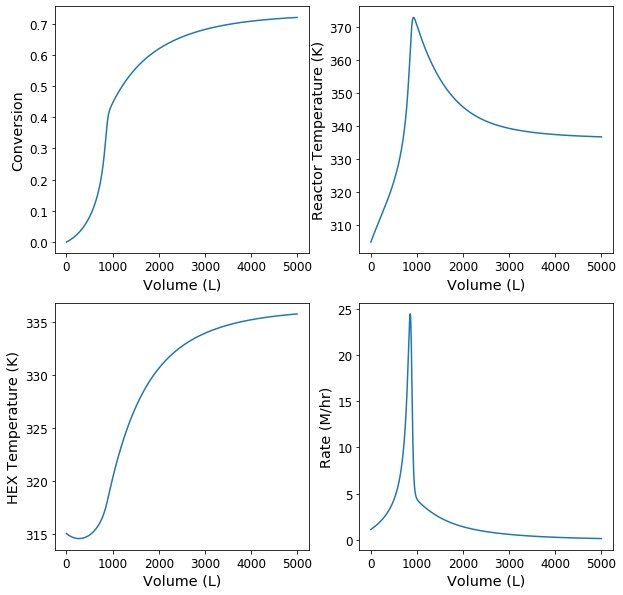

In [19]:
#Co-current Heat Exchanger
sol_cocurrent = np.asarray(odeint(deriv_cocurrent, [0, T0, Ta_entry], V_range, args = (5000,))) #Integrate the combined balances and convert output to np array
print(f'Final conversion with co-current HEX is {float(sol_cocurrent[-1,0]):.3f}')
fig, ax = plt.subplots(2,2, figsize = [10,10])

ax[0, 0].plot(V_range, sol_cocurrent[:,0])
ax[0, 0].set_xlabel('Volume (L)')
ax[0, 0].set_ylabel('Conversion')
ax[0, 1].plot(V_range, sol_cocurrent[:,1])
ax[0, 1].set_xlabel('Volume (L)')
ax[0, 1].set_ylabel('Reactor Temperature (K)')
ax[1,0].plot(V_range, sol_cocurrent[:,2])
ax[1,0].set_xlabel('Volume (L)')
ax[1,0].set_ylabel('HEX Temperature (K)')
ax[1,1].plot(V_range, rate(sol_cocurrent[:,0], sol_cocurrent[:,1]))
ax[1,1].set_xlabel('Volume (L)')
ax[1,1].set_ylabel('Rate (M/hr)')

Final conversion is with no HEX is 0.366


Text(0, 0.5, 'Rate (M/hr)')

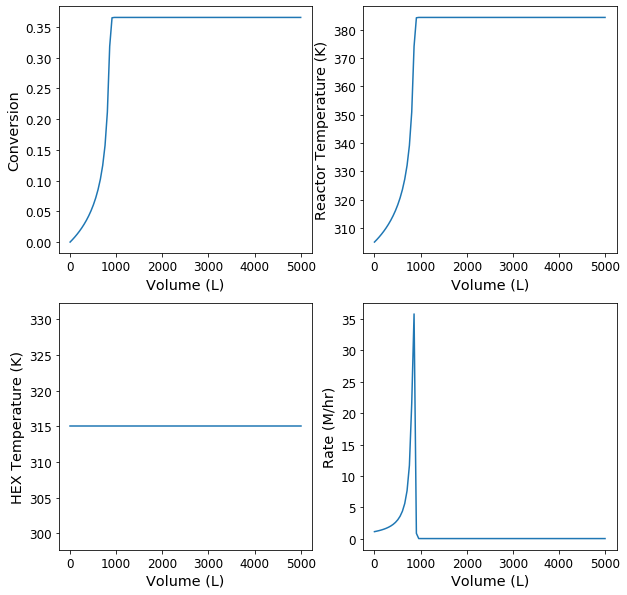

In [9]:
#Adiabatic operation
sol_adiabatic = np.asarray(odeint(deriv_cocurrent, [0, T0, Ta_entry], V_range, args = (0,))) #Integrate the combined balances and convert output to np array
print(f'Final conversion is with no HEX is {float(sol_adiabatic[-1,0]):.3f}')
fig, ax = plt.subplots(2,2, figsize = [10,10])

ax[0, 0].plot(V_range, sol_adiabatic[:,0])
ax[0, 0].set_xlabel('Volume (L)')
ax[0, 0].set_ylabel('Conversion')
ax[0, 1].plot(V_range, sol_adiabatic[:,1])
ax[0, 1].set_xlabel('Volume (L)')
ax[0, 1].set_ylabel('Reactor Temperature (K)')
ax[1,0].plot(V_range, sol_adiabatic[:,2])
ax[1,0].set_xlabel('Volume (L)')
ax[1,0].set_ylabel('HEX Temperature (K)')
ax[1,1].plot(V_range, rate(sol_adiabatic[:,0], sol_adiabatic[:,1]))
ax[1,1].set_xlabel('Volume (L)')
ax[1,1].set_ylabel('Rate (M/hr)')

## Counter-Current Operation - The Shooting Method
If you look closely at the differential equation for the counter-current heat exchanger, you'll see it's actually a boundary value proble, NOT an initial value problem: We know the feed temperature at the END of the reactor(Ta0), but for our ODE solver, we need to start from Ta2, which we don't know a-priori. A nifty solution to this is what's called the Shooting Method. We basically wrap our ODE solver in an optimization algorithm, where we GUESS a value for Ta2 to start from, see what value of Ta we end up at, and minimize the difference between this and Ta0. 

In [11]:
#Counter-current operation
def deriv_counter(Y, V): #PFR mole balance WITH COUNTERCURRENT HEX in differential form
    X, T, Ta = Y
    ra = rate(X,T)
    dXdV = ra/FA0
    dTdV = (-ra*H_rxn-Ua*(T-Ta))/(FA0*summation)
    dTadV = -Ua*(T-Ta)/(mc*cpc)
    return dXdV, dTdV, dTadV

In [12]:
#Write a function that computes the trajectories with an initial guess of Ta2 and spits out the difference between Ta0_calculated and the target Ta0
def shoot(guess):
    Ta2 = guess[0] #Pass in as a vector so that I can use minimize (not scalar) and therefore pass an initial guess
    sol_counter = np.asarray(odeint(deriv_counter, [0, T0, Ta2], V_range, rtol=1E-10)) #Integrate the combined balances and convert output to np array
        
    Ta0 = sol_counter[-1,2] #Last element in column 2 is Ta0
    error = (Ta_entry-Ta0)**2
    print(f'Ta0: {Ta0:.2f}, error^2: {error:.3f}')
    return float(error)

In [13]:
shoot([300])

Ta0: 289.71, error^2: 639.786


639.7858645033951

In [17]:
res = minimize(shoot, [250])
res

Ta0: 238.60, error^2: 5836.230
Ta0: 238.60, error^2: 5836.230
Ta0: 238.60, error^2: 5836.230
Ta0: 239.80, error^2: 5654.328
Ta0: 239.80, error^2: 5654.328
Ta0: 239.80, error^2: 5654.328
Ta0: 244.60, error^2: 4956.704
Ta0: 244.60, error^2: 4956.704
Ta0: 244.60, error^2: 4956.704
Ta0: 263.47, error^2: 2654.865
Ta0: 263.47, error^2: 2654.865
Ta0: 263.47, error^2: 2654.865
Ta0: 282.95, error^2: 1027.039
Ta0: 282.95, error^2: 1027.039
Ta0: 282.95, error^2: 1027.039
Ta0: 321.59, error^2: 43.477
Ta0: 321.59, error^2: 43.477
Ta0: 321.59, error^2: 43.477
Ta0: 310.67, error^2: 18.789
Ta0: 310.67, error^2: 18.789
Ta0: 310.67, error^2: 18.789
Ta0: 314.33, error^2: 0.455
Ta0: 314.33, error^2: 0.455
Ta0: 314.33, error^2: 0.455
Ta0: 315.08, error^2: 0.006
Ta0: 315.08, error^2: 0.006
Ta0: 315.08, error^2: 0.006
Ta0: 315.00, error^2: 0.000
Ta0: 315.00, error^2: 0.000
Ta0: 315.00, error^2: 0.000
Ta0: 315.00, error^2: 0.000
Ta0: 315.00, error^2: 0.000
Ta0: 315.00, error^2: 0.000


      fun: 7.876531545000132e-12
 hess_inv: array([[0.32289602]])
      jac: array([-6.95476271e-06])
  message: 'Optimization terminated successfully.'
     nfev: 33
      nit: 8
     njev: 11
   status: 0
  success: True
        x: array([340.3549413])

Final conversion with counter-current HEX is 0.763


Text(0, 0.5, 'Rate (M/hr)')

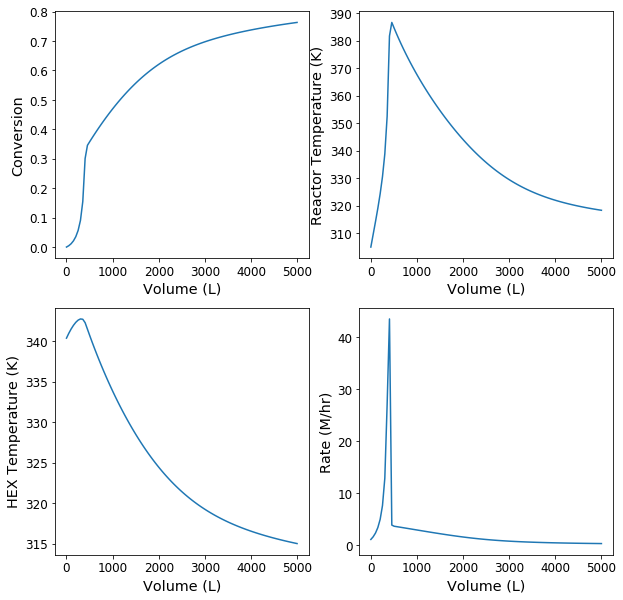

In [15]:
Ta2 = res.x[0]
sol_counter, info_dict = np.asarray(odeint(deriv_counter, [0, T0, Ta2], V_range, full_output = True)) #Integrate the combined balances and convert output to np array
print(f'Final conversion with counter-current HEX is {float(sol_counter[-1,0]):.3f}')

fig, ax = plt.subplots(2,2, figsize = [10,10])

ax[0, 0].plot(V_range, sol_counter[:,0])
ax[0, 0].set_xlabel('Volume (L)')
ax[0, 0].set_ylabel('Conversion')
ax[0, 1].plot(V_range, sol_counter[:,1])
ax[0, 1].set_xlabel('Volume (L)')
ax[0, 1].set_ylabel('Reactor Temperature (K)')
ax[1,0].plot(V_range, sol_counter[:,2])
ax[1,0].set_xlabel('Volume (L)')
ax[1,0].set_ylabel('HEX Temperature (K)')
ax[1,1].plot(V_range, rate(sol_counter[:,0], sol_counter[:,1]))
ax[1,1].set_xlabel('Volume (L)')
ax[1,1].set_ylabel('Rate (M/hr)')